In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from gumbel_V5_NS_shGLM import gumbel_NS_shGLM
from sklearn import metrics
import torch.distributions as dist

# Hyperparams

In [2]:
train_T = 65000
test_T = 15000
T_syn = 100
T_hist = 100
C_den = torch.zeros(5,5)
C_den[0,1:] = 1
#C_den = torch.zeros(1).reshape(1,1)
sub_no = C_den.shape[0]

batch_size = 1500

syn_basis_no = 1
hist_basis_no = 1
prop_basis_no = 1


In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
#Ensyn = torch.tensor([0+106+213+211+99])
#Insyn = torch.tensor([1+22+36+42+19])
E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]

# Train Params

In [4]:
model = gumbel_NS_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([15000])


In [5]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

In [6]:
repeat_no = 1
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

63500
63500


In [7]:
#optimizer = optim.Adam(model.parameters(), lr=0.00001)
optimizer = optim.Adam(model.parameters(), lr=0.005)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)


33


In [8]:
#batch_no = 10000
loss_array = np.empty((batch_no//100, 2))

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred= model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
        
    diff = (batch_ref - batch_pred) ** 1
    var_loss = torch.var(diff)

    
    loss = var_loss
    #print(i, var_loss.item(), torch.mean(batch_spikes).item())

        
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        #print(torch.mean(test_spikes, 0).cpu().detach().numpy())
        #print(torch.mean(spike_probs, 0).cpu().detach().numpy())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/cont_shglm/baseGLMmono_L23_sub5_b4_i"+str(i)+".pt")
            loss_array[i//100,0] = i
            loss_array[i//100,1] = test_score
            np.save("/media/hdd01/sklee/cont_shglm/baseGLMmono_L23_sub5_b4_test_scores.npy", loss_array)


<ipython-input-8-d187f8d06303>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 39.95320669267462 0.009017906193561465 0.009857878930770725
TEST 50 37.55254196626796 0.06856295786494315 0.0603710941775788
TEST 100 34.835857642409465 0.13594642321950268 0.15830003939862058
TEST 150 32.558364660535055 0.19243637609350417 0.19850440598899965
TEST 200 30.5443455663735 0.24239123638329685 0.26907897540452375
TEST 250 28.519500998892276 0.2926146070440101 0.2525743576910765
TEST 300 26.844617861288427 0.3341576854627438 0.328832927814784
TEST 350 25.436041809477423 0.3690953978527146 0.35563134430794596
TEST 400 24.013332289226298 0.40438367072433823 0.4303224675327698
TEST 450 22.956599207745885 0.43059442193383424 0.41861089816174146
TEST 500 21.851213755026436 0.4580119255951992 0.4522573884183033
TEST 550 21.00650149986779 0.47896380374799596 0.4453775829120191
TEST 600 20.0135296171065 0.5035930497456946 0.46594837742648376
TEST 650 19.130797368559694 0.5254879593998836 0.565046889428479
TEST 700 18.251524404482502 0.5472970664878225 0.5036841065811839
TEST 

TEST 6250 5.4954477500960826 0.8636932860088629 0.8465515241543129
TEST 6300 6.456093163422629 0.839865851775855 0.809653901104824
TEST 6350 5.154764729138697 0.87214344059881 0.815729245773323
TEST 6400 5.16473272081042 0.8718961988301452 0.818938150425499
TEST 6450 5.59472471872771 0.8612308629402867 0.533210131712734
TEST 6500 5.387624658147315 0.8663676834113712 0.856615868250703
TEST 6550 5.148921900101454 0.87228836362607 0.8355021969472507
TEST 6600 5.647539616519598 0.8599208649568093 0.8776226657288169
TEST 6650 5.04749421601605 0.8748041321069419 0.8421972198125981
TEST 6700 5.22254653952361 0.8704622098248037 0.8450917002430683
TEST 6750 5.35115704046509 0.8672722104537777 0.7848291807703629
TEST 6800 5.205617154757974 0.8708821189688514 0.761225734628726
TEST 6850 5.035092692064465 0.8751117341580377 0.7253809341987143
TEST 6900 5.651768582558416 0.8598159715133652 0.832030547802423
TEST 6950 5.452428839089695 0.8647603084690707 0.803415593565205
TEST 7000 5.1306577107165 0

TEST 12500 4.9066089137729145 0.8782985903338818 0.65984177511736
TEST 12550 4.831917427923 0.8801512057129047 0.8499769560198529
TEST 12600 5.194989761419314 0.8711457162540384 0.8172488263396683
TEST 12650 6.067345268052185 0.8495081867725054 0.7801516063192823
TEST 12700 5.449266574624887 0.8648387439129106 0.8556729926813532
TEST 12750 5.3593700593078 0.8670684982876801 0.7980625743638754
TEST 12800 5.191816641024434 0.8712244209598334 0.758526758427397
TEST 12850 5.166310048391033 0.8718570754787008 0.7885057941996837
TEST 12900 4.863257173268881 0.8793738682050134 0.7575442125000984
TEST 12950 5.880614490605081 0.854139776378391 0.824260872275119
TEST 13000 4.834245674783839 0.8800934568940352 0.8874624219831057
TEST 13050 4.834354902526916 0.8800907476528408 0.7552097053657216
TEST 13100 4.965234261578763 0.8768444725320956 0.7702474635598688
TEST 13150 4.8833157859171905 0.8788763430389026 0.8133531549774702
TEST 13200 4.928620297300667 0.877752629474113 0.8999060513332133
TEST

TEST 18650 5.010811684085637 0.8757139898235264 0.7650288865013128
TEST 18700 4.757316156453057 0.8820015834579352 0.8296239535694638
TEST 18750 4.7844525895144985 0.8813285030904633 0.8607332908824774
TEST 18800 5.01960390360917 0.8754959113666861 0.8024312691630525
TEST 18850 4.931041181849478 0.8776925829011587 0.8231480067772369
TEST 18900 4.810215604086406 0.8806894883859775 0.870746820588642
TEST 18950 4.867252707998798 0.8792747646775015 0.7808616929133981
TEST 19000 4.9121163480336305 0.8781619863089882 0.8050971921566265
TEST 19050 5.030132357714342 0.8752347681372502 0.7295578815424821
TEST 19100 4.844476052124617 0.8798397070198095 0.877552375992715
TEST 19150 5.073174258317471 0.8741671754121132 0.7398266127502832
TEST 19200 4.782563632987885 0.8813753559503632 0.7706322082175462
TEST 19250 4.838918302579317 0.8799775590405152 0.799031432913255
TEST 19300 4.852786270556098 0.8796335839502212 0.8689568122519411
TEST 19350 4.976842913675625 0.876556536511426 0.765080762793755

TEST 24800 4.85712055035988 0.8795260783420319 0.8305058892521927
TEST 24850 4.9836392828308 0.8763879623053191 0.8447163749746771
TEST 24900 4.95628137498689 0.8770665360428431 0.8513354979444929
TEST 24950 4.871612505583809 0.8791666261398559 0.8011030170370677
TEST 25000 4.832905181054296 0.8801267059127438 0.8203495616527662
TEST 25050 4.832670888220065 0.8801325172112998 0.8567579364804688
TEST 25100 4.796347759483359 0.8810334604192286 0.8696219616518734
TEST 25150 4.798984187587652 0.880968067594063 0.8102443386104144
TEST 25200 4.7996835089977985 0.88095072192661 0.8956365471819584
TEST 25250 4.825280571089287 0.8803158234464112 0.7720211288042401
TEST 25300 4.8898111827654525 0.8787152340040278 0.8334285934686737
TEST 25350 4.845693025295746 0.8798095217408468 0.8584832373633561
TEST 25400 4.754937697287913 0.8820605777341315 0.8442626175288801
TEST 25450 4.8551282398944275 0.8795754947520826 0.8627769503538416
TEST 25500 4.816635771871198 0.8805302453157511 0.81051960316905
T

TEST 30950 4.753633283823594 0.8820929318409525 0.7795234352610949
TEST 31000 4.804696422845091 0.8808263837762006 0.9018782950302842
TEST 31050 4.8068821526645475 0.8807721698788411 0.8706532020296954
TEST 31100 4.826095925225119 0.8802955997542432 0.8561230063000445
TEST 31150 4.8234420272707395 0.8803614258936318 0.7777867462108877
TEST 31200 4.781555533060389 0.8814003604202794 0.8091109540598667
TEST 31250 4.754058970698281 0.8820823732892401 0.8564678125399322
TEST 31300 4.759610737853131 0.8819446696507848 0.8788045596739529
TEST 31350 4.762804131372113 0.8818654620967913 0.8433590198332391
TEST 31400 4.8042366941374315 0.8808377866892463 0.8692524007046762
TEST 31450 4.829721826998996 0.8802056644508921 0.8568658493820217
TEST 31500 4.83458953421507 0.8800849279435038 0.7901684588173654
TEST 31550 4.817912257163484 0.8804985839261288 0.8587269625805175
TEST 31600 4.857406697021641 0.8795189808835115 0.7185387837943125
TEST 31650 4.823329323989932 0.8803642213372781 0.8481261460

TEST 37100 4.828726778068733 0.8802303452155821 0.8253719339379673
TEST 37150 4.788588728515813 0.8812259120761501 0.8487589159914803
TEST 37200 4.810071862185178 0.8806930536996892 0.847443817527428
TEST 37250 4.773856526733289 0.8815913232520983 0.8390827640941789
TEST 37300 4.806179889467502 0.8807895885113401 0.7502523523410112
TEST 37350 4.8171007914328605 0.8805187111723991 0.8662688455229215
TEST 37400 4.775757757428704 0.881544165946611 0.8768898271223322
TEST 37450 4.7998586501377405 0.8809463778045288 0.8819696028132705
TEST 37500 4.763229314381618 0.8818549160420065 0.853384061900109
TEST 37550 4.773690518264087 0.8815954408553053 0.8310464081225685
TEST 37600 4.815238514294637 0.8805649022909017 0.8182889604419818
TEST 37650 4.811289251380452 0.8806628581038215 0.7514347106375163
TEST 37700 4.890467012232714 0.8786989670943883 0.8194108911556202
TEST 37750 4.812957487176041 0.8806214799026679 0.7876533950888205
TEST 37800 4.777906133589408 0.8814908785500943 0.8455139140099

TEST 43250 4.7672776233880105 0.8817545035298062 0.7738190008940146
TEST 43300 4.791630469753462 0.8811504660374095 0.8535680923274547
TEST 43350 4.7832146896196495 0.8813592074162152 0.8536019022566553
TEST 43400 4.791812001159672 0.881145963411121 0.8902388969710149
TEST 43450 4.820459554704336 0.8804354018561809 0.8544915540404234
TEST 43500 4.811331419642208 0.8806618121791266 0.8121879409941942
TEST 43550 4.804143195752763 0.8808401057820776 0.8169560425847099
TEST 43600 4.790814044968176 0.881170716286251 0.8489463294987583
TEST 43650 4.803144614742206 0.8808648741547246 0.8620330845345846
TEST 43700 4.813783007500753 0.88060100405203 0.7701343614230534
TEST 43750 4.815513523831873 0.880558081071525 0.8583660706426248
TEST 43800 4.791879128560171 0.8811442984118785 0.8612328039255686
TEST 43850 4.792071378239939 0.8811395299337443 0.8615798521497965
TEST 43900 4.799290179283528 0.8809604779076908 0.9062736565985532
TEST 43950 4.840732232844344 0.879932567096054 0.8687903702566253

TEST 49400 4.807653751778291 0.8807530314653016 0.8563506743098646
TEST 49450 4.7955841030062585 0.8810524018246347 0.776709079371648
TEST 49500 4.777557851161941 0.8814995171960988 0.8320217074259093
TEST 49550 4.7815652192411795 0.8814001201676709 0.8261105668744383
TEST 49600 4.790781722295849 0.8811715180032741 0.8094686666152329
TEST 49650 4.794470968672748 0.8810800115284003 0.8481819700329373
TEST 49700 4.799198311650056 0.8809627565533527 0.6831524053393339
TEST 49750 4.794480886035969 0.8810797655425285 0.8227447578974595
TEST 49800 4.816839027422052 0.8805252038524461 0.9133042540984172
TEST 49850 4.833879708324013 0.880102534157547 0.8364033208472811
TEST 49900 4.816586110306004 0.8805314770995539 0.8836450349006661
TEST 49950 4.807265920767763 0.8807626510586629 0.8283097246939792
TEST 50000 4.815402037414669 0.8805608463324096 0.8406933678300563
TEST 50050 4.796151526565275 0.8810383276958406 0.8695329662831082
TEST 50100 4.79893053101213 0.8809693984689531 0.8102585823818

TEST 55550 4.7882202693976685 0.8812350511766283 0.8526006069926095
TEST 55600 4.780579251097761 0.8814245756970093 0.8087524998199991
TEST 55650 4.785454179239871 0.8813036600831198 0.7237869780242605
TEST 55700 4.787248552676238 0.8812591532186661 0.8944315108780965
TEST 55750 4.787955227766635 0.8812416251546629 0.8317182145350561
TEST 55800 4.7922018558798625 0.881136293623594 0.8546556432950062
TEST 55850 4.793351194272115 0.8811077859301204 0.884879387369319
TEST 55900 4.795685744240092 0.8810498807601354 0.7703848904302848
TEST 55950 4.798787257406951 0.8809729521660297 0.7558594845211244
TEST 56000 4.79713010049996 0.8810140555707486 0.8731233876318707
TEST 56050 4.7972465625740615 0.8810111668957087 0.8718735633502103
TEST 56100 4.7991801771912845 0.8809632063532161 0.8420564133902289
TEST 56150 4.800907985966151 0.8809203505299504 0.8534507247745478
TEST 56200 4.799214667133527 0.8809623508794919 0.7548191714871457
TEST 56250 4.796793209730789 0.881022411663943 0.819916421704

TEST 61700 4.801524780265867 0.8809050518299666 0.6944518404497707
TEST 61750 4.80108904379097 0.8809158596494362 0.8724064398839462
TEST 61800 4.800399939243283 0.8809329519012593 0.8333657946935932
TEST 61850 4.7991942429088095 0.8809628574728263 0.8375001508749642
TEST 61900 4.7956954906988996 0.8810496390127355 0.8833232993418633
TEST 61950 4.794408321486791 0.8810815654024029 0.8545761626727599
TEST 62000 4.7994197990795096 0.8809572628749203 0.63038563402643
TEST 62050 4.795968993991551 0.881042855155091 0.825735479852697
TEST 62100 4.796553676822115 0.8810283529344999 0.8961501838167327
TEST 62150 4.794572257463756 0.881077499205182 0.8061104493588396
TEST 62200 4.793620820043626 0.8811010982483638 0.8534813621698737
TEST 62250 4.793053952567806 0.8811151585845949 0.8107757222885795
TEST 62300 4.7925328267254415 0.8811280843651208 0.8429672536448589
TEST 62350 4.791704636384017 0.8811486264409556 0.8831574648993921
TEST 62400 4.792420626188139 0.8811308673388334 0.83403429547346

# Test 

In [4]:
model = gumbel_NS_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/baseGLMmono_L23_sub5_b4_i63400.pt"))
model = model.float().to("cuda")

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()[:]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()


0.9391835189819819


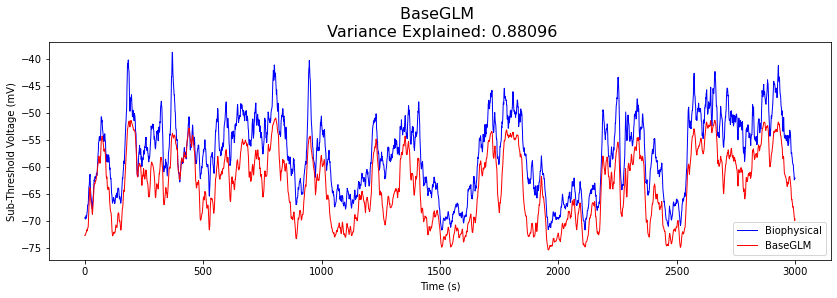

In [6]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[5000:8000], label="Biophysical", c="blue", linewidth=1)
plt.plot(test_V_final[5000:8000]-17,label="BaseGLM", c="red", linewidth=1)
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("BaseGLM \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


#plt.savefig("/media/hdd01/sklee/cont_shglm/BaseGLM_L23_sub5_b4.png", dpi=150, bbox_inches='tight')#

In [7]:
#np.save("/media/hdd01/sklee/cont_shglm/baseglmmono_L23_sub5_b4_test.npy", test_V_final)

In [8]:
tau = model.Tau_syn.cpu().detach().numpy()
delta = model.Delta_syn.cpu().detach().numpy()
weights = model.W_syn.cpu().detach().numpy()

e_kern = np.zeros((sub_no, T_syn))
i_kern = np.zeros((sub_no, T_syn))

t = np.arange(T_syn)
for s in range(sub_no):
    t_e = t - delta[s,0]
    t_i = t - delta[s,1]
    t_e[t_e < 0.0] = 0.0
    t_i[t_i < 0.0] = 0.0
    for b in range(syn_basis_no):
        t_tau_e = t_e / np.exp(tau[b,0])
        t_tau_i = t_i / np.exp(tau[b,1])
        
        part_e_kern = t_tau_e * np.exp(-t_tau_e)
        part_i_kern = t_tau_i * np.exp(-t_tau_i)
        
        e_kern[s] += part_e_kern * weights[s,b,0]
        i_kern[s] += part_i_kern * weights[s,b,1]
        
for s in range(sub_no):
    e_kern[s] /= np.max(np.abs(e_kern[s]))
    i_kern[s] /= np.max(np.abs(i_kern[s]))

In [9]:
#np.save("/media/hdd01/sklee/cont_shglm/baseglmmono_L23_sub5_b4_e_kern.npy", e_kern)
#np.save("/media/hdd01/sklee/cont_shglm/baseglmmono_L23_sub5_b4_i_kern.npy", i_kern)

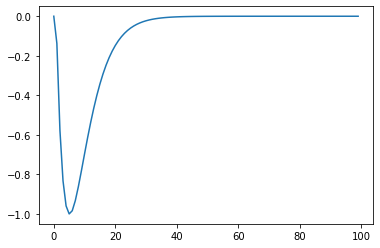

In [10]:
plt.plot(i_kern[2])